In [31]:
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("data/pm.csv")
df.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


# EDA

In [33]:
df=df[['national']]
df.head()

,national
0,47
1,59
2,59
3,59
4,59


50.502231696755715
<class 'float'>


/home/fei/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


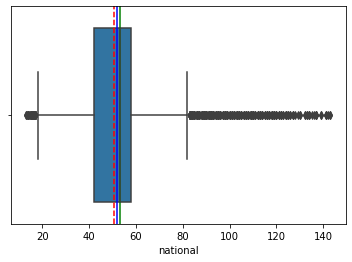

In [34]:
import seaborn as sns
f, (ax_box) = plt.subplots(1, sharex=True)
mean=df['national'].mean()
median=df['national'].median()
mode=df['national'].mode()[0]
print(mean)
print(type(median))
sns.boxplot(df["national"], ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

In [35]:
def no_outliers(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    valid_values = ~((x < (Q1 - 1.5 * IQR)) |(x > (Q3 + 1.5 * IQR)))
    return valid_values

In [36]:
df.loc[no_outliers(df.national)==False,'national']=np.nan
df.loc[no_outliers(df.national)==False,'national']=np.nan
df.fillna(int(median),inplace=True)

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
national,30022.0,50.029745,11.576476,18.0,42.0,53.0,58.0,82.0


# MLE

In [44]:
from scipy.special import psi, polygamma

# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [45]:
# Calculate statistics
log_mean = df.mean().apply(np.log)
mean_log = df.apply(np.log).mean()

In [46]:
# Alpha MLE for December
from scipy.special import psi, polygamma
from scipy.optimize import newton
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

16.074479572466274

In [47]:
beta_mle = alpha_mle/df.mean()[-1]
beta_mle

0.3212984519399108

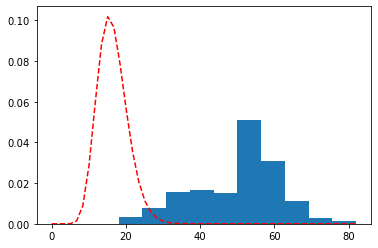

In [63]:
from scipy.stats.distributions import gamma

dec = df.national
dec.hist(density=True, bins=10, grid=False)
x = np.linspace(0, dec.max())
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')

In [49]:
from scipy.stats import gamma

gamma.fit(df.national)

(300.0814872168602, -153.56159180330246, 0.6780547580841858)

In [50]:
from pymc3 import fit
from pymc3 import Model, Uniform, StudentT, Normal

RANDOM_SEED = 20090425

with Model() as air_model:
    μ_0 = Normal('μ_0', 100, sd=10)
    μ_1 = Normal('μ_1', 100, sd=10)
    
with air_model: 
    Air_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 1.5


Got error No model on context stack. trying to find log_likelihood in translation.


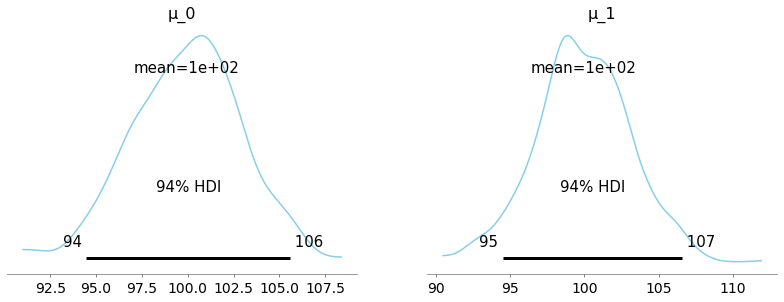

In [60]:
from pymc3 import plot_posterior

plot_posterior(Air_trace[100:], 
                color='#87ceeb');

Got error No model on context stack. trying to find log_likelihood in translation.
/home/fei/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


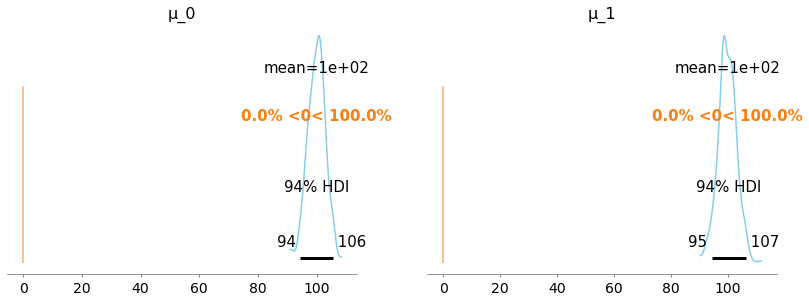

In [61]:
plot_posterior(Air_trace[100:], 
          ref_val=0,
          color='#87ceeb');